In [1]:
!pip install transformers
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 13.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 8.1 MB/s eta 0:00:00


In [2]:
import torch as t
from transformers import GPT2LMHeadModel, GPT2Tokenizer # pip install transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
import matplotlib.pyplot as plt
import time
import numpy as np
import sklearn
import pickle
import re # regular expressions, useful for decoding the output
import pandas as pd

In [3]:
def create_dataset(i_start=0, i_end=50, operation=t.add):

    """(1 pt) Create a dataset of pairs of numbers to calculate an operation
    on.
    DO NOT USE A FOR LOOP. 
    Use pytorch functions, possibilities include
    meshgrid, stack, reshape, repeat, tile.
    (Note you'll have to use for loops on string stuff in other functions)
    The dataset should be a tuple of two tensors, X and y, where X is a Nx2
    tensor of numbers to add,
    and y is a N tensor of the correct answers.
    E.g., if i_start=0, i_end=2, then X should be
    tensor([[0,0,1,1],[0,1,0,1]]).T and y should be tensor([0,1,1,2]).

    I recommend doing all pairs of sums involving 0-49, but you may modify
    this.
    """
    # TODO 

    # Create tensors for the x and y values
    x1 = t.arange(i_start, i_end)
    x2 = t.arange(i_start, i_end)

    # # Using MeshGrid
    # x1, x2 = t.meshgrid(x1, x2)
    # x1 = x1.reshape(-1)
    # x2 = x2.reshape(-1)
    # X = t.stack((x1, x2), dim=1)

    # Using Tile
    x1 = x1.tile(((i_end - i_start),1))
    x1 = x1.T.reshape(-1,)
    x2 = x2.tile(((i_end - i_start)))
    X = t.stack((x1, x2), dim=0)

    # Perform the desired operation (addition in this case)
    
    if operation == t.add:
        y = x1 + x2    


    return X, y

In [4]:
def load_LLM(default="EleutherAI/gpt-neo-2.7B", device='cpu'):
    """(1 pt) Load a pretrained LLM and put on device. Default choice is a
    large-ish GPT-neo-2.7B model on Huggingface.
    Could also consider the "open GPT" from facebook: "facebook/opt-2.7b", or
    others
    here: https://huggingface.co/models?pipeline_tag=text-generation

    Explicitly load model and tokenizer, don't use the huggingface "pipeline"
    which hides details of the model
    (and it also has no batch processing, which we need here) """
    
    # TODO

    # load model from huggingface
    model = AutoModelForCausalLM.from_pretrained(default, torch_dtype=t.float16)
    # move model to gpu
    model.to(device)
    # load tokenizer from huggingface
    tokenizer = AutoTokenizer.from_pretrained(default)

    return model, tokenizer

In [5]:
def encode_problems(X, strategy='baseline'):
    """(1 pts) Encode the problems as strings. For example, if X is
    [[0,0,1,1],[0,1,0,1]],
    then the baseline output should be ["0+0=", "0+1=", "1+0=", "1+1="]""" 
    
    # Encode the problem based on various prompts.
    # In case nothing is provided, use baseline

    output_strings = []
    
    for xi in X.T:
        if strategy == 'word_problem':
            encode_string ="Add {} and {}".format(xi[0], xi[1])
        elif strategy == 'code':
            encode_string ="A={}, B={}, A+B=".format(xi[0], xi[1])
        elif strategy == 'algebra':
            encode_string ="if x={} and y={} and z=x+y, then what is z?".format(xi[0], xi[1])
        elif strategy == 'in_context':
            encode_string ="if 7+11=18 and 31+22=55 then {}+{}=".format(xi[0], xi[1])
        else:
            encode_string = "{}+{}=".format(xi[0],xi[1])
        
        output_strings.append(encode_string) 
    
    return output_strings

In [6]:
def generate_text(model, tokenizer, prompts, verbose=True, device='cpu'): 
    """(3 pts) Complete the prompt using the LLM.
    1. Tokenize the prompts:
    https://huggingface.co/docs/transformers/preprocessing
        Put data and model on device to speed up computations
        (Note that in real life, you'd use a dataloader to do this efficiently
    in the background during training.)
    2. Generate text using the model.
        Turn off gradient tracking to save memory.
        Determine the sampling hyper-parameters.
        You may need to do it in batches, depending on memory constraints
    3. Use the tokenizer to decode the output.
    You will need to optionally print out the tokenization of the input and
    output strings for use in the write-up.
    """

    t0 = time.time()

    # TODO: tokenize
    encoded_input = tokenizer(prompts, return_tensors="pt").input_ids.to(device)

    print ()
    # # TODO: generate text, turn off gradient tracking 
    output = []
    batch = 50
    with t.no_grad():
        for i in range(0,encoded_input.shape[0],batch):
            if i + batch <= encoded_input.shape[0]:
                output.extend(model.generate(encoded_input[i:i+batch]))
            else:
                output.extend(model.generate(encoded_input[i:encoded_input.shape[0]]))
    
    # # TODO: decode output, output_strings = ...
    output_strings = []

    for out in output:
        output_strings.append(tokenizer.decode(out))
    
    if verbose:

        # TODO: print example tokenization for write-up
        print ('____________')
        print ('input')
        print (prompts[0])
        print ('____________')
        print ('____________')
        print ('output')
        print (output_strings[0])
        print ('____________')
        print("Time to generate text: ", time.time() - t0) # It took 4 minutes to do 25000 prompts on an NVIDIA 1080Ti.

    return output_strings

In [7]:
def decode_output(output_strings, strategy='baseline', verbose=True):
    """(1 pt) Decode the output strings into a list of integers. Use "t.nan"
    for failed responses.
    One suggestion is to split on non-numeric characters, then convert to int.
    And use try/except to catch errors.
    """

    # Use regex to get the first numerical value.
    # In case no numerical value, store nan
    # We only look at first value as we have removed the input string from this output
    import re

    # TODO: 
    y_hat = []
    for s in output_strings:
        y = re.findall(r'-?\d+(?:\.\d+)?', s)
        y_hat.append(float(y[0]) if len(y)>0 else t.nan)

    return y_hat

In [8]:
def linear_classifier(X,y, strategy):

    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.neural_network import MLPClassifier
    from sklearn.metrics import confusion_matrix, classification_report

    clf = MLPClassifier(hidden_layer_sizes=(64,64,64,64,32,16,8,), activation='relu', solver='lbfgs', max_iter = 1000, )
    clf.fit(X, y)

    y_pred = clf.predict(X)
    acc = np.sum(y_pred == y)/y_pred.shape[0]

    cm = confusion_matrix(y, y_pred)
    fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1])

    print(f"False negative rate: {fnr}")
    print ('acc of classifier is {}'.format(acc))

    def plot_decision_regions(clf, X, y, resolution=0.1):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                            np.arange(y_min, y_max, resolution))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.3)

    plt.title('{}, addition, MLP Classifier'.format(strategy))
    plt.xlabel('x1')
    plt.ylabel('x2')
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    plt.xticks(np.arange(x_min, x_max, step=2))
    plt.yticks(np.arange(x_min, x_max, step=2))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plot_decision_regions(clf, X, y)
    plt.legend()
    plt.show()

    return acc, fnr

In [9]:
def analyze_results(X, y, y_hats, strategies):
    """(3 pts) Analyze the results.
    Output the accuracy of each strategy.
    Plot a scatter plot of the problems “x1+x2” with x1,x2 on each axis,
    and different plot markers to indicate whether the answer from your LLM was
    correct.
    (See write-up instructions for requirements on plots)
    Train a classifier to predict whether the LLM gave the correct response
    (using scikit-learn, for example)
    and plot the classifier boundary over the scatter plot with “contour”. (Use
    whatever classifier looks appropriate)"""


    results_list = []


    for strategy, y_hat in zip(strategies, y_hats):

        print ()
        print (' ____________ ')
        print (strategy)
        # accuracy of strategies
        accuracy = t.sum(t.tensor(y_hat) == y)/ len(y_hat)
        print ('accuracy of {} is {}'.format(strategy, accuracy))

        # scatter plot
        correct = []
        incorrect = []
        for x1, x2, true,pred in zip(X[0], X[1], y,y_hat):
            if true == pred:
                correct.append([x1,x2])
            else:
                incorrect.append([x1,x2]) 

        correct = t.tensor(correct)
        incorrect = t.tensor(incorrect)

        plt.title('{}, addition'.format(strategy))
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.xticks(np.arange(min(X[0])-2, max(X[0])+2, step=2))
        plt.yticks(np.arange(min(X[1])-2, max(X[1])+2, step=2))
        if len(correct):
            plt.scatter(correct[:,0], correct[:,1], c='green', s=25, label='correct')
        if len(incorrect):
            plt.scatter(incorrect[:,0], incorrect[:,1], c='red', s=25, label='incorrect')
        plt.legend()
        plt.show()

        # classifier
        # create a dataset for classifier

        x_train = X.T
        y_train = [1 if i else 0 for i in y == t.tensor(y_hat)]
        if len(correct):
            acc, fnr = linear_classifier(x_train, y_train, strategy)
            results_list.append({'strategy':strategy, 'miss_rate (in %)':fnr*100, 'accuracy (in %)':accuracy.item()*100, 'classifier_accuracy (in %)':acc*100})
        else:
            results_list.append({'strategy':strategy, 'miss_rate (in %)':'N/A', 'accuracy (in %)':accuracy.item()*100, 'classifier_accuracy (in %)':0})

    df = pd.DataFrame.from_records(results_list)
    print ('The resultant Accuracies')
    print ()
    print ()
    print (df)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_ma

____________
input
Add 10 and 10
____________
____________
output
Add 10 and 10 and add 10 and 10 and add 10 and 10 and add 10 and 10 and
____________
Time to generate text:  19.851578950881958


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

____________
input
A=10, B=10, A+B=
____________
____________
output
A=10, B=10, A+B=20, C=10, D=
____________
Time to generate text:  10.36656904220581



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 20, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 20, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_toke

____________
input
if x=10 and y=10 and z=x+y, then what is z?
____________
____________
output
if x=10 and y=10 and z=x+y, then what is z?

____________
Time to generate text:  5.338148832321167



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

____________
input
if 7+11=18 and 31+22=55 then 10+10=
____________
____________
output
if 7+11=18 and 31+22=55 then 10+10=20 and 10
____________
Time to generate text:  6.860901355743408



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

____________
input
10+10=
____________
____________
output
10+10=10+10=10+10=10+10=10+10=
____________
Time to generate text:  16.137332916259766

 ____________ 
word_problem
accuracy of word_problem is 0.0


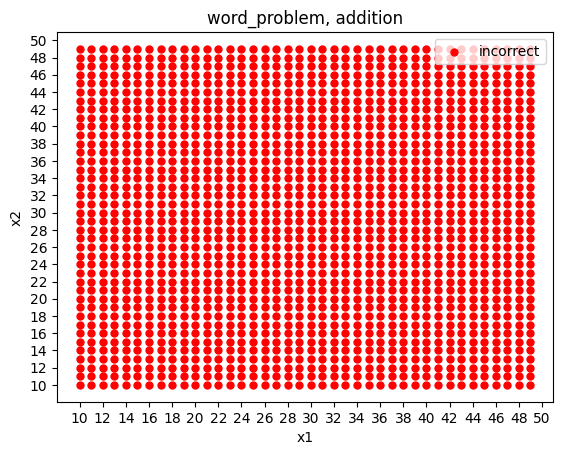


 ____________ 
code
accuracy of code is 0.010625000111758709


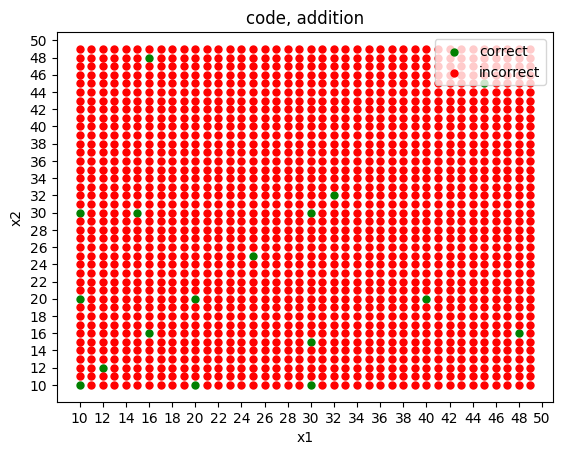

False negative rate: 1.0
acc of classifier is 0.989375


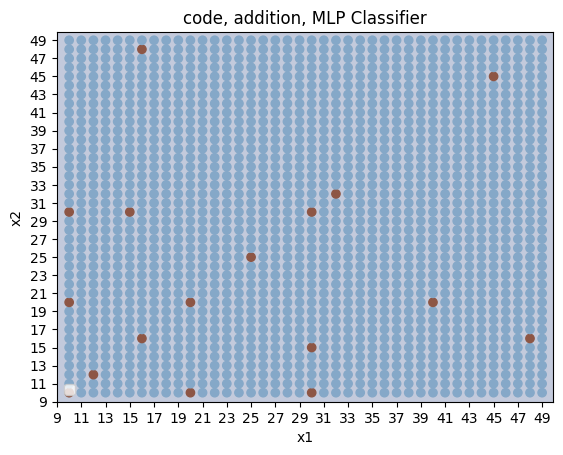


 ____________ 
algebra
accuracy of algebra is 0.0


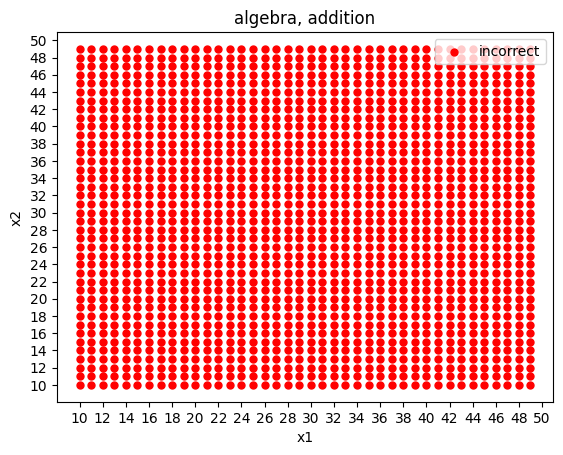


 ____________ 
in_context
accuracy of in_context is 0.09062500298023224


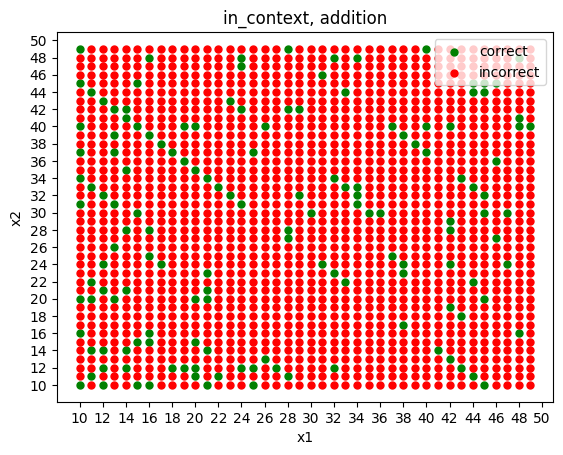

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


False negative rate: 1.0
acc of classifier is 0.909375


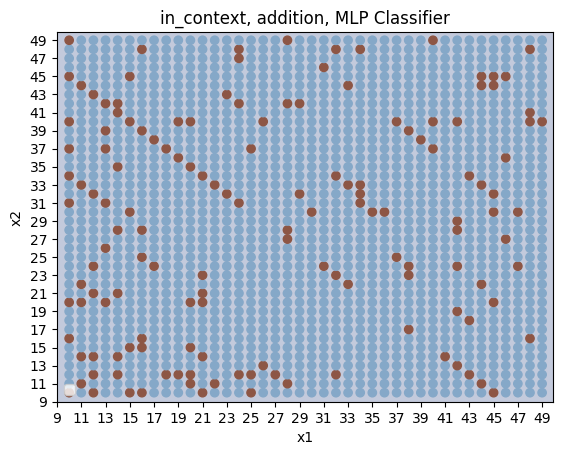


 ____________ 
baseline
accuracy of baseline is 0.0012499999720603228


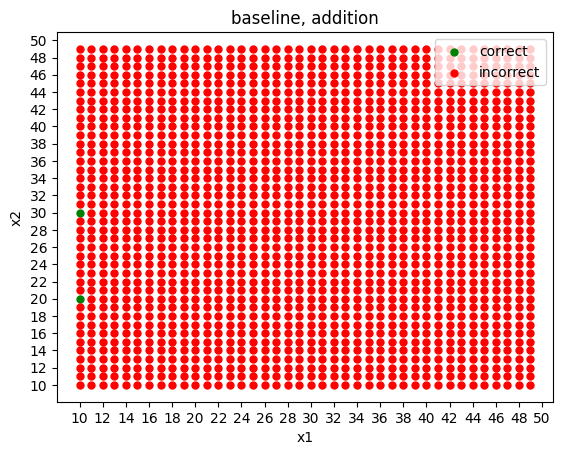

False negative rate: 0.0
acc of classifier is 1.0


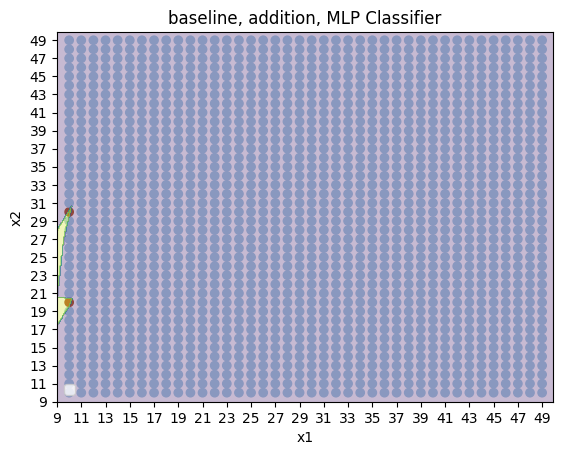

The resultant Accuracies


       strategy miss_rate (in %)  accuracy (in %)  classifier_accuracy (in %)
0  word_problem              N/A           0.0000                      0.0000
1          code            100.0           1.0625                     98.9375
2       algebra              N/A           0.0000                      0.0000
3    in_context            100.0           9.0625                     90.9375
4      baseline              0.0           0.1250                    100.0000


In [10]:
if __name__ == "__main__":
    device = t.device("cuda" if t.cuda.is_available() else "cpu") # Use GPU if available

    # Create Dataset of X and Y
    X, y = create_dataset(10, 50)

    # # Load model and tokenizer.
    # # Currently using EleutherAI/gpt-neo-1.3B as EleutherAI/gpt-neo-2.7B is not being loaded on GPU
    model_names = ['EleutherAI/gpt-neo-2.7B', 'EleutherAI/gpt-neo-1.3B','facebook/opt-2.7b', 'EleutherAI/gpt-neo-125m']
    model_to_use = model_names[1]
    model, tokenizer = load_LLM(default = model_to_use, device=device)
    

    # list of lists of predicted answers, y_hat, for each strategy 
    y_hats = [] 
    
    # Various strategies to be used
    strategies = ['word_problem', 'code', 'algebra', 'in_context', 'baseline']

    for strategy in strategies:

        # print (strategy)
        # encode string based on strategy
        input_strings = encode_problems(X, strategy=strategy)
        # print ('input_strings')
        # print (input_strings)

        # generate output by passing it through the model
        output_strings = generate_text(model, tokenizer, input_strings, verbose = True, device=device)
        # print ('output_strings')
        # print (output_strings)

        # # Remove the input string from generated answer
        offset = 0

        if model_to_use == model_names[2]:
            offset = 4

        output_strings_updated = [out_s[offset+len(in_s):] for in_s, out_s in zip(input_strings, output_strings)] 
        # print ('output_strings_updated')
        # print (output_strings_updated)

        # decode the output to get first numerical number or nan
        y_hat = decode_output(output_strings_updated, strategy=strategy)
        # print ('y_hat')
        # print (y_hat)

        # append to lists
        y_hats.append(y_hat) 
    
    # analyze the output
    analyze_results(X, y, y_hats, strategies)

In [12]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [13]:
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended
!jupyter nbconvert --log-level CRITICAL --to pdf ./CS_229_HW_1_CalcGPT.ipynb

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ Packages [76.4 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [993 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
0% [Connecting to ppa.launchpad.net (185.125.190.52)]^C